In [4]:
import pandas as pd
import numpy as np
import re

from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from numpy.random import seed
from tensorflow import set_random_seed

from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import rcParams
%matplotlib inline
rcParams['figure.figsize'] = 10,8
sns.set(style='whitegrid', palette='muted',
        rc={'figure.figsize': (15,10)})

# Any results you write to the current directory are saved as output.

In [5]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
IDtest = test["PassengerId"]

In [6]:
full_data = [train, test]

# Some features of my own that I have added in
# Gives the length of the name
train['Name_length'] = train['Name'].apply(len)
test['Name_length'] = test['Name'].apply(len)
# Feature that tells whether a passenger had a cabin on the Titanic
train['Has_Cabin'] = train["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
test['Has_Cabin'] = test["Cabin"].apply(lambda x: 0 if type(x) == float else 1)

# Feature engineering steps taken from Sina
# Create new feature FamilySize as a combination of SibSp and Parch
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
# Create new feature IsAlone from FamilySize
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
# Remove all NULLS in the Embarked column
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
# Remove all NULLS in the Fare column and create a new feature CategoricalFare
for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())
train['CategoricalFare'] = pd.qcut(train['Fare'], 4)
# Create a New feature CategoricalAge
for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)
train['CategoricalAge'] = pd.cut(train['Age'], 5)
# Define function to extract titles from passenger names
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""
# Create a new feature Title, containing the titles of passenger names
for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)
# Group all non-common titles into one single grouping "Rare"
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

for dataset in full_data:
    # Mapping Sex
    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
    # Mapping titles
    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)
    
    # Mapping Embarked
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
    
    # Mapping Fare
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] 						        = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] 							        = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    # Mapping Age
    dataset.loc[ dataset['Age'] <= 16, 'Age'] 					       = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] = 4 ;
    
# Feature selection
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(drop_elements, axis = 1)
train = train.drop(['CategoricalAge', 'CategoricalFare'], axis = 1)
test  = test.drop(drop_elements, axis = 1)

C:\Python36\lib\site-packages\ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [7]:
from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(n_splits=10)

X = train.drop(['Survived'], axis=1)
y = train.iloc[:, 0].ravel()

In [125]:
def create_model(lyrs=[8], act='linear', opt='Adam', dr=0.0, dr2=0.0):
    
    # set random seed for reproducibility
    seed(42)
    set_random_seed(42)
    
    model = Sequential()
    
    # create first hidden layer
    model.add(Dense(lyrs[0], input_dim=X.shape[1], activation=act))
    
    # create additional hidden layers
    for i in range(1,len(lyrs)):
        model.add(Dense(lyrs[i], activation=act))
        model.add(Dropout(dr2))
    
    # add dropout, default is none
    model.add(Dropout(dr))
    
    # create output layer
    model.add(Dense(1, activation='sigmoid'))  # output layer
    
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    return model

In [9]:
model = create_model()
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 96        
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 105
Trainable params: 105
Non-trainable params: 0
_________________________________________________________________
None


In [8]:
# train model on full train set, with 80/20 CV split
training = model.fit(X, y, epochs=50, batch_size=16, validation_split=0.2, verbose=0)
val_acc = np.mean(training.history['val_acc'])
print("\n%s: %.2f%%" % ('val_acc', val_acc*100))


val_acc: 78.53%


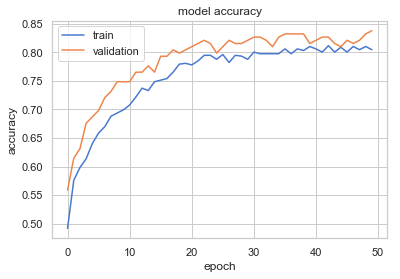

In [9]:
# summarize history for accuracy
plt.plot(training.history['acc'])
plt.plot(training.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [17]:
# create model
model = KerasClassifier(build_fn=create_model, verbose=0)

# define the grid search parameters
batch_size = [16, 32, 64]
epochs = [50, 100]
param_grid = dict(batch_size=batch_size, epochs=epochs)

# search the grid
grid = GridSearchCV(estimator=model, 
                    param_grid=param_grid,
                    cv=3,
                    verbose=1)#, n_jobs=-1)  # include n_jobs=-1 if you are using CPU

grid_result = grid.fit(X, y)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:  2.8min finished


In [18]:
# Summarize Results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.806958 using {'batch_size': 16, 'epochs': 100}
0.803591 (0.005723) with: {'batch_size': 16, 'epochs': 50}
0.806958 (0.005723) with: {'batch_size': 16, 'epochs': 100}
0.801347 (0.013746) with: {'batch_size': 32, 'epochs': 50}
0.802469 (0.003174) with: {'batch_size': 32, 'epochs': 100}
0.760943 (0.019824) with: {'batch_size': 64, 'epochs': 50}
0.803591 (0.004199) with: {'batch_size': 64, 'epochs': 100}


In [19]:
# create model
model = KerasClassifier(build_fn=create_model, epochs=50, batch_size=16, verbose=0)

# define the grid search parameters
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Nadam']
param_grid = dict(opt=optimizer)

# search the grid
grid = GridSearchCV(estimator=model, param_grid=param_grid, verbose=1)
grid_result = grid.fit(X, y)

C:\Python36\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:  3.3min finished


In [20]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.804714 using {'opt': 'Adam'}
0.673401 (0.066663) with: {'opt': 'SGD'}
0.781145 (0.012598) with: {'opt': 'RMSprop'}
0.794613 (0.004762) with: {'opt': 'Adagrad'}
0.785634 (0.008837) with: {'opt': 'Adadelta'}
0.804714 (0.004762) with: {'opt': 'Adam'}
0.769921 (0.035880) with: {'opt': 'Nadam'}


In [23]:
seed(42)
set_random_seed(42)

# create model
model = KerasClassifier(build_fn=create_model, 
                        epochs=100, batch_size=16, 
                        validation_split=0.2, verbose=0)

# define the grid search parameters
layers = [[6],[8],[10],[12],[6,6],[8,8],[10,10],[12,12]]
param_grid = dict(lyrs=layers)

# search the grid
grid = GridSearchCV(estimator=model, param_grid=param_grid, verbose=1)
grid_result = grid.fit(X, y)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:  7.8min finished


In [24]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.808081 using {'lyrs': [8, 8]}
0.806958 (0.005723) with: {'lyrs': [6]}
0.801347 (0.009912) with: {'lyrs': [8]}
0.800224 (0.008399) with: {'lyrs': [10]}
0.803591 (0.009655) with: {'lyrs': [12]}
0.800224 (0.005723) with: {'lyrs': [6, 6]}
0.808081 (0.010997) with: {'lyrs': [8, 8]}
0.799102 (0.011111) with: {'lyrs': [10, 10]}
0.801347 (0.014547) with: {'lyrs': [12, 12]}


In [39]:
# create model
model = KerasClassifier(build_fn=create_model, 
                        epochs=100, batch_size=16, verbose=0)

# define the grid search parameters
drops = [0.0, 0.01, 0.05, 0.1, 0.2, 0.5]
param_grid = dict(dr=drops)
grid = GridSearchCV(estimator=model, param_grid=param_grid, verbose=2)
grid_result = grid.fit(temp_X, y)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:  3.0min finished


In [40]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.806958 using {'dr': 0.1}
0.802469 (0.005723) with: {'dr': 0.0}
0.800224 (0.004199) with: {'dr': 0.01}
0.804714 (0.005498) with: {'dr': 0.05}
0.806958 (0.001587) with: {'dr': 0.1}
0.803591 (0.003174) with: {'dr': 0.2}
0.801347 (0.009912) with: {'dr': 0.5}


In [10]:
# Create x, where x the 'scores' column's values as floats
x = X['Name_length'].values.astype(float).reshape(-1,1)

# Create a minimum and maximum processor object
min_max_scaler = preprocessing.MinMaxScaler()

# Create an object to transform the data to fit minmax processor
x_scaled = min_max_scaler.fit_transform(x)

# Run the normalizer on the dataframe
df_normalized = pd.DataFrame(x_scaled)

# df_normalized.plot(kind='bar')

temp_X = X

temp_X['Name_length'] = df_normalized.values

temp_X[:10]

,Pclass,Sex,Age,Parch,Fare,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,Title
0,3,1,1,0,0,0,0.157143,0,2,0,1
1,1,0,2,0,3,1,0.557143,1,2,0,3
2,3,0,1,0,1,0,0.142857,0,1,1,2
3,1,0,2,0,3,0,0.457143,1,2,0,3
4,3,1,2,0,1,0,0.171429,0,1,1,1
5,3,1,2,0,1,2,0.057143,0,1,1,1
6,1,1,3,0,3,0,0.157143,1,1,1,1
7,3,1,0,1,2,0,0.257143,0,5,0,4
8,3,0,1,2,1,0,0.528571,0,3,0,3
9,2,0,0,0,2,1,0.328571,0,2,0,3


In [239]:
# create final model
model = create_model(lyrs=[11,16,16,16,11], dr=0.1, dr2=0.75, act='relu')

# print(model.summary())

# train model on full train set, with 80/20 CV split

earlyStopping = EarlyStopping(monitor='val_loss', patience=80, verbose=0, mode='auto')#, restore_best_weights=True)
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=40, verbose=0, mode='auto')

training = model.fit(temp_X, y, epochs=500, batch_size=32, 
                     validation_split=0.2, verbose=0)
                     #callbacks=[earlyStopping, reduce_lr_loss])#, shuffle=True)

# evaluate the model
scores = model.evaluate(temp_X, y)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

891/891 [==============================] - 0s 98us/step

acc: 81.37%


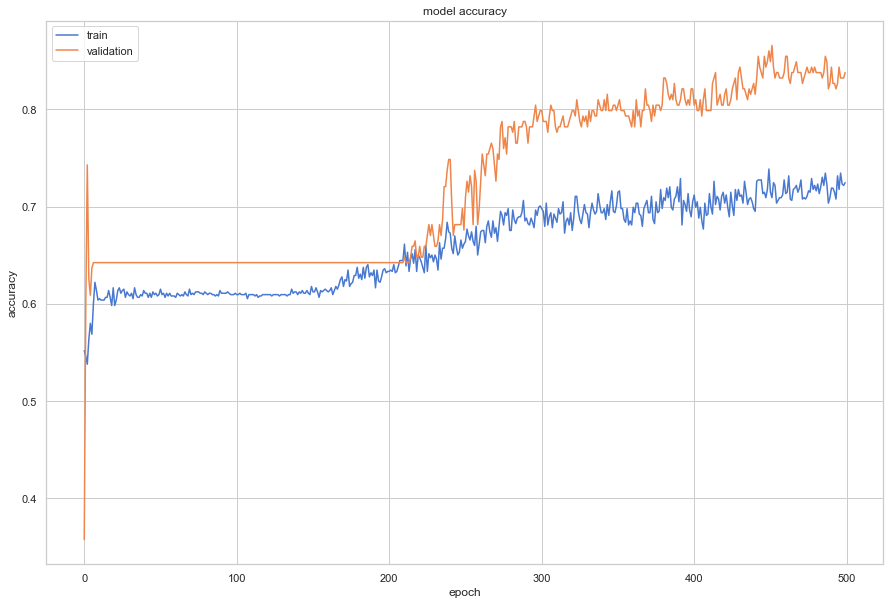

In [240]:
# summarize history for accuracy
plt.plot(training.history['acc'])
plt.plot(training.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

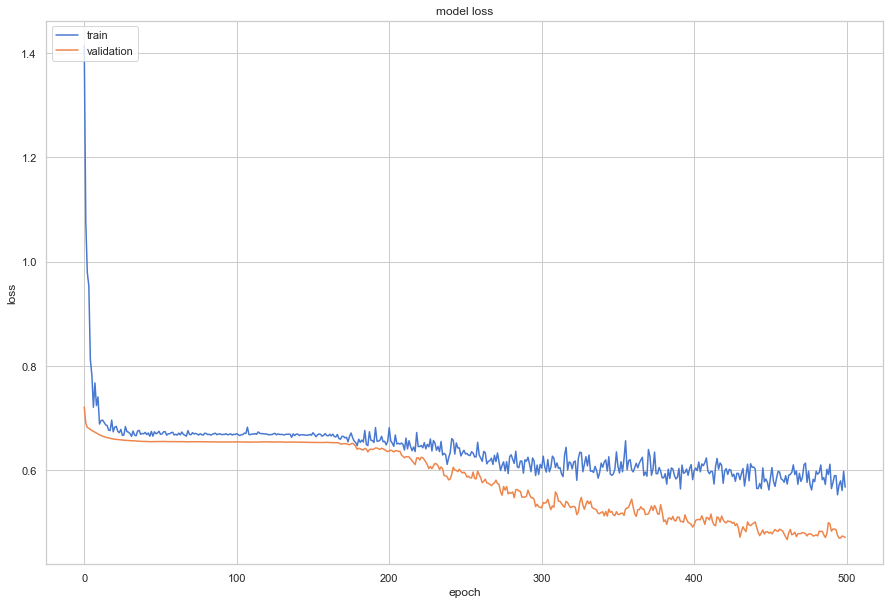

In [241]:
# summarize history for accuracy
plt.plot(training.history['loss'])
plt.plot(training.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [180]:
# Create x, where x the 'scores' column's values as floats
x = test['Name_length'].values.astype(float).reshape(-1,1)

# Create a minimum and maximum processor object
min_max_scaler = preprocessing.MinMaxScaler()

# Create an object to transform the data to fit minmax processor
x_scaled = min_max_scaler.fit_transform(x)

# Run the normalizer on the dataframe
df_normalized = pd.DataFrame(x_scaled)

# df_normalized.plot(kind='bar')

temp_test = test

temp_test['Name_length'] = df_normalized.values

temp_test[:10]

,Pclass,Sex,Age,Parch,Fare,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,Title
0,3,1,2,0,0,2,0.06,0,1,1,1
1,3,0,2,0,0,0,0.38,0,2,0,3
2,2,1,3,0,1,2,0.24,0,1,1,1
3,3,1,1,0,1,0,0.06,0,1,1,1
4,3,0,1,1,1,0,0.62,0,3,0,3
5,3,1,0,0,1,0,0.26,0,1,1,1
6,3,0,1,0,0,2,0.14,0,1,1,2
7,2,1,1,1,2,0,0.30,0,3,0,1
8,3,0,1,0,0,1,0.56,0,1,1,3
9,3,1,1,0,2,0,0.20,0,3,0,1


In [181]:
test_Survived = pd.Series(model.predict(temp_test).reshape((-1,)), name="Survived")
test_Survived = test_Survived.apply(lambda x: round(x,0)).astype('int')

results = pd.concat([IDtest,test_Survived],axis=1)

results.to_csv("ensemble_python_voting3.csv",index=False)